# Day 5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 역전파 신경망

In [2]:
import numpy as np

class Sigmoid:
    def __init__(self):
        self.y = None

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        y = 1 / (1 + np.exp(-x))
        self.y = y
        return y

    def backward(self, dout):
        dx = dout * self.y * (1 - self.y)
        return dx

class 완전연결:
    def __init__(self, 입력수, 출력수, 활성화=None):
        self.W = np.random.randn(입력수, 출력수)
        self.b = np.zeros(출력수)
        self.activation = 활성화
        self.x = None
        self.dW = None
        self.db = None

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        self.x = x
        z = np.dot(x, self.W) + self.b
        if self.activation:
            return self.activation(z)
        return z

    def backward(self, dout):
        if self.activation:
            dout = self.activation.backward(dout)
            
        self.dW = np.dot(self.x.T, dout)
        # 배치 단위 연산 시, 미분값을 모든 표본에 대해 더합니다.
        self.db = np.sum(dout, axis=0)
        
        dx = np.dot(dout, self.W.T)
        return dx

def softmax(z):
    if z.ndim == 1:
        z = z.reshape(1, -1)
    exp_z = np.exp(z - np.max(z, axis=1).reshape(-1, 1))
    return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)

def 교차엔트로피오차(y, y_pred):
    delta = 1e-7
    배치크기 = y.shape[0]
    return -np.sum(y * np.log(y_pred + delta)) / 배치크기

class CrossEntropy:
    def __init__(self, from_logits=False):
        self.y = None
        self.from_logits = from_logits
        self.proba = None

    def __call__(self, z, y):
        return self.forward(z, y)

    def forward(self, outputs, y):
        self.y = y
        # z -> softmax -> proba
        if not self.from_logits:      
            self.proba = outputs
        else: # from_logits=True -> 실수값 -> 확률값
            self.proba = softmax(outputs)
        # CEE(y, proba)
        손실 = 교차엔트로피오차(y, self.proba)
        return 손실

    def backward(self, dout=1):
        배치크기 = len(self.y)
        dz = self.proba - self.y
        return dz / 배치크기

class 역전파신경망:
    def __init__(self, 손실함수):
        self.layers = []
        self.loss_func = 손실함수

    def add(self, layer):
        self.layers.append(layer)

    def __call__(self, x):
        """순전파"""
        outputs = x
        for layer in self.layers:
            outputs = layer(outputs)
        return outputs # z_last

    def 손실산출(self, x, y):
        outputs = self(x)
        손실 = self.loss_func(outputs, y)
        return 손실

    def fit(self, x, y, 배치크기, 에폭수, 학습률):
        에폭당_배치수 = len(x) // 배치크기
        학습횟수 = 에폭당_배치수 * 에폭수
        print(f'배치크기={배치크기}, 에폭수={에폭수}, 학습횟수={학습횟수}({에폭당_배치수}/에폭)')
        손실변화 = []
        for 학습 in range(학습횟수):
            # 1. 미니 배치
            표본수 = S = len(x)
            배치색인 = np.random.choice(표본수, 배치크기)
            x_batch = x[배치색인]
            y_batch = y[배치색인]
            # 2. 경사 산출 (역전파)
            # 1) 순전파
            손실 = self.손실산출(x_batch, y_batch)
            손실변화.append(손실)
            # 2) 역전파            
            dout = self.loss_func.backward(1)
            for layer in reversed(self.layers):
                dout = layer.backward(dout)
            # 3. 매개변수 갱신 (경사 하강)
            for layer in self.layers:
                if isinstance(layer, 완전연결):
                    layer.W -= layer.dW * 학습률
                    layer.b -= layer.db * 학습률

            if 학습 == 0 or (학습 + 1) % 100 == 0:
                print(f'[학습 {학습 + 1}] Loss: {손실:.3f}')
        return 손실변화


## MNIST

In [3]:
from torchvision.datasets import MNIST

mnist = {}
mnist['train'] = MNIST(root='~/data', train=True, download=True)
mnist['test'] = MNIST(root='~/data', train=False, download=True)

In [4]:
def 전처리(images):
    if not isinstance(images, np.ndarray):
        images = np.array(images)
    X = images.astype(np.float32)
    X = X.reshape(-1, 28 * 28)
    X = X / 255.0
    return X

train_data = 전처리(mnist['train'].data)
train_target = np.array(mnist['train'].targets)
test_data = 전처리(mnist['test'].data)
test_target = np.array(mnist['test'].targets)
print(train_data.shape, test_data.shape)
assert np.isclose(train_data.max(), 1.0) and np.isclose(train_data.min(), 0.0)
assert np.isclose(test_data.max(), 1.0) and np.isclose(test_data.min(), 0.0)

(60000, 784) (10000, 784)


배치크기=100, 에폭수=10, 학습횟수=6000(600/에폭)
[학습 1] Loss: 8.757
[학습 100] Loss: 0.905
[학습 200] Loss: 0.602
[학습 300] Loss: 0.720
[학습 400] Loss: 0.527
[학습 500] Loss: 0.333
[학습 600] Loss: 0.416
[학습 700] Loss: 0.587
[학습 800] Loss: 0.539
[학습 900] Loss: 0.166
[학습 1000] Loss: 0.443
[학습 1100] Loss: 0.634
[학습 1200] Loss: 0.394
[학습 1300] Loss: 0.293
[학습 1400] Loss: 0.200
[학습 1500] Loss: 0.261
[학습 1600] Loss: 0.362
[학습 1700] Loss: 0.198
[학습 1800] Loss: 0.331
[학습 1900] Loss: 0.195
[학습 2000] Loss: 0.264
[학습 2100] Loss: 0.233
[학습 2200] Loss: 0.186
[학습 2300] Loss: 0.135
[학습 2400] Loss: 0.372
[학습 2500] Loss: 0.177
[학습 2600] Loss: 0.221
[학습 2700] Loss: 0.261
[학습 2800] Loss: 0.255
[학습 2900] Loss: 0.208
[학습 3000] Loss: 0.237
[학습 3100] Loss: 0.184
[학습 3200] Loss: 0.224
[학습 3300] Loss: 0.178
[학습 3400] Loss: 0.142
[학습 3500] Loss: 0.189
[학습 3600] Loss: 0.262
[학습 3700] Loss: 0.316
[학습 3800] Loss: 0.189
[학습 3900] Loss: 0.170
[학습 4000] Loss: 0.138
[학습 4100] Loss: 0.291
[학습 4200] Loss: 0.307
[학습 4300] Loss: 0.168
[학습 4400

<Axes: >

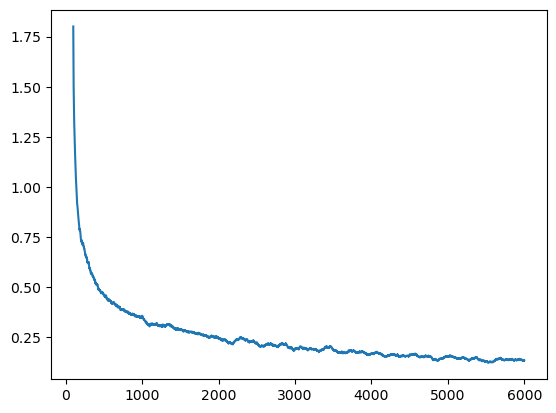

In [5]:
model = 역전파신경망(손실함수=CrossEntropy(from_logits=True))
model.add(완전연결(입력수=28*28, 출력수=50, 활성화=Sigmoid()))
model.add(완전연결(입력수=50, 출력수=100, 활성화=Sigmoid()))
model.add(완전연결(입력수=100, 출력수=10, 활성화=None))

원핫행렬 = np.eye(10)
loss_history = model.fit(train_data, 원핫행렬[train_target], 배치크기=100, 에폭수=10, 학습률=1.0)
# 평가
outputs = model(test_data)
y_pred = np.argmax(outputs, axis=1)
print(f'정확도: {np.mean(y_pred == test_target):.2%}')
# 손실 그래프
display(pd.Series(loss_history).rolling(window=100).mean().plot())

## PyTorch

PyTorch = NumPy + GPU + Backprop + ...

In [6]:
import torch

사과단가 = torch.tensor(100.0, requires_grad=True)
사과수량 = torch.tensor(2.0, requires_grad=True)
부가세 = torch.tensor(0.1)

사과가격 = 사과단가 * 사과수량 * (1 + 부가세)
사과가격.backward()

pd.DataFrame({
    '사과단가': [사과단가.item(), 사과단가.grad.item()],
    '사과수량': [사과수량.item(), 사과수량.grad.item()],
    '부가세': [부가세.item(), 부가세.grad]
}, index=['순전파', '역전파'])

,사과단가,사과수량,부가세
순전파,100.0,2.0,0.1
역전파,2.2,110.0,NaN


In [7]:
x = torch.tensor(1/3)
print(x) # 텐서 객체
print(f'{x.item():.2f}') # 파이썬 숫자형 값 (스칼라)

tensor(0.3333)
0.33


## 파이토치 신경망

In [12]:
import torch

class 다중퍼셉트론:
    def __init__(self, 입력수, 출력수, 활성화=None):
        self.W = torch.randn(입력수, 출력수, requires_grad=True)
        self.b = torch.zeros(출력수, requires_grad=True)
        self.활성화 = 활성화

    def __call__(self, x):
        z = torch.matmul(x, self.W) + self.b
        if self.활성화:
            z = self.활성화(z)
        return z
    
layer = 다중퍼셉트론(입력수=2, 출력수=3, 활성화=torch.sigmoid)
print(layer.W.shape, layer.b.shape)
assert layer.W.requires_grad and layer.b.requires_grad

X = torch.linspace(0, 1, 10).reshape(5, 2)
outputs = layer(X)


torch.Size([2, 3]) torch.Size([3])


In [ ]:
import torch.nn as nn # 신경망 모듈

layer = nn.Linear(in_features=2, out_features=3)
print(layer.weight.shape, layer.bias.shape)
assert layer.weight.requires_grad and layer.bias.requires_grad

X = torch.linspace(0, 1, 10).reshape(5, 2)
assert torch.allclose(layer(X), X @ layer.weight.T + layer.bias)
# 활성화 (직접 해야 합니다.)
Z = torch.sigmoid(layer(X))

torch.Size([3, 2]) torch.Size([3])


In [32]:
def build_model():
    model = nn.Sequential(
        # 은닉층
        nn.Linear(in_features=784, out_features=50),
        nn.Sigmoid(), # 비선형 활성화
        nn.Linear(in_features=50, out_features=100),
        nn.Sigmoid(), # 비선형 활성화
        # 출력층
        nn.Linear(in_features=100, out_features=10)
    )
    return model

# 학습
model = build_model() # 신경망 모델 생성 (초기화)
손실함수 = nn.CrossEntropyLoss() # 로짓값을 입력으로 받음, 정답은 정수값 (원핫인코딩 하지 않음)
학습률 = 1.0; 학습횟수 = 100

train_data = mnist['train'].data.reshape(-1, 28*28).float() / 255.0
for 에폭 in range(학습횟수):
    손실변화 = []
    outputs = model(train_data)
    손실 = 손실함수(outputs, mnist['train'].targets)
    손실변화.append(손실.item())
    print(f'[에폭 {에폭+1}/{학습횟수}] 손실: {손실:.3f}')
    # 역전파
    손실.backward()
    # 매개변수 갱신
    with torch.no_grad():
        for param in model.parameters():
            param -= param.grad * 학습률
        model.zero_grad() # 기울기 초기화

# 평가
test_data = mnist['test'].data.reshape(-1, 28*28).float() / 255.0
outputs = model(test_data)
print(outputs.shape)
y_pred = torch.argmax(outputs, dim=1)
print(f'정확도: {torch.mean((y_pred == mnist["test"].targets).float()):.2%}')

[에폭 1/100] 손실: 2.351
[에폭 2/100] 손실: 2.421
[에폭 3/100] 손실: 2.591
[에폭 4/100] 손실: 2.496
[에폭 5/100] 손실: 2.607
[에폭 6/100] 손실: 2.522
[에폭 7/100] 손실: 2.591
[에폭 8/100] 손실: 2.447
[에폭 9/100] 손실: 2.472
[에폭 10/100] 손실: 2.411
[에폭 11/100] 손실: 2.410
[에폭 12/100] 손실: 2.388
[에폭 13/100] 손실: 2.378
[에폭 14/100] 손실: 2.364
[에폭 15/100] 손실: 2.352
[에폭 16/100] 손실: 2.345
[에폭 17/100] 손실: 2.335
[에폭 18/100] 손실: 2.331
[에폭 19/100] 손실: 2.324
[에폭 20/100] 손실: 2.322
[에폭 21/100] 손실: 2.318
[에폭 22/100] 손실: 2.314
[에폭 23/100] 손실: 2.314
[에폭 24/100] 손실: 2.308
[에폭 25/100] 손실: 2.310
[에폭 26/100] 손실: 2.302
[에폭 27/100] 손실: 2.306
[에폭 28/100] 손실: 2.298
[에폭 29/100] 손실: 2.301
[에폭 30/100] 손실: 2.293
[에폭 31/100] 손실: 2.297
[에폭 32/100] 손실: 2.289
[에폭 33/100] 손실: 2.292
[에폭 34/100] 손실: 2.285
[에폭 35/100] 손실: 2.288
[에폭 36/100] 손실: 2.280
[에폭 37/100] 손실: 2.283
[에폭 38/100] 손실: 2.276
[에폭 39/100] 손실: 2.278
[에폭 40/100] 손실: 2.270
[에폭 41/100] 손실: 2.273
[에폭 42/100] 손실: 2.264
[에폭 43/100] 손실: 2.266
[에폭 44/100] 손실: 2.258
[에폭 45/100] 손실: 2.260
[에폭 46/100] 손실: 2.2

## 배치 크기

원래보다 작은 크기로도 전체 손실 추정이 가능할 수 있습니다. 선거에서 출구 조사와 비슷합니다.

In [58]:
import time

model = build_model()
손실함수 = nn.CrossEntropyLoss()

# 처음 시작 시, "워밍 업" 단계
_ = model(train_data)

results = {}
# 전체 데이터
for 배치크기 in [1, 10, 100, 600, 1000, 6000, len(train_data)]:
    # 무작위로 배치 선택
    배치색인 = torch.randint(0, len(train_data), (배치크기,))
    # print(f'배치크기={배치크기}\t표본색인: {배치색인[:5].numpy()} ...')
    소요시간 = []
    for _ in range(5): # 5회 반복 (평균 시간 측정)
        start = time.time()
        outputs = model(train_data[배치색인])
        손실 = 손실함수(outputs, mnist['train'].targets[배치색인])
        end = time.time()
        소요시간.append(end - start)
    results[f'{배치크기}'] = {'손실': 손실.item(), '소요시간 (ms)': np.mean(소요시간) * 1000}

pd.DataFrame(results).round(3)

,1,10,100,600,1000,6000,60000
손실,1.980,2.262,2.328,2.331,2.340,2.330,2.333
소요시간 (ms),3.948,0.221,1.411,0.559,0.858,5.644,81.668


In [ ]:
model = build_model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device) # 모델을 GPU 또는 CPU로 이동
W1 = next(model.parameters()) # 첫 번째 매개변수 (가중치)
print(W1.device)

cuda:0


In [91]:
import time

model = build_model() # 신경망 모델 생성 (초기화)
손실함수 = nn.CrossEntropyLoss() # 로짓값을 입력으로 받음
최적화 = torch.optim.SGD(model.parameters(), lr=1.0)

에폭수 = 60; 배치크기 = 600
에폭당_배치수 = len(train_data) // 배치크기
학습횟수 = 에폭당_배치수 * 에폭수
print(f'배치크기={배치크기}, 에폭수={에폭수}, 학습횟수={학습횟수}({에폭당_배치수}/에폭)')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device) # 모델을 GPU 또는 CPU로 이동
# train_data = train_data.to(device) # 전체 데이터를 GPU로 복사. 권장하지 않음...

손실변화 = []; 에폭당_소요시간 = []
for 에폭 in range(에폭수):
    start = time.time()
    for _ in range(에폭당_배치수):
        # 미니 배치
        배치색인 = torch.randperm(len(train_data))[:배치크기]
        # 배치 데이터와 타겟을 GPU로 이동
        batch_data = train_data[배치색인].to(device)
        batch_target = mnist['train'].targets[배치색인].to(device)
        # 순전파
        loss = 손실함수(model(batch_data), batch_target)
        손실변화.append(loss.item())
        # print(f'손실: {손실변화[-1]:.3f}')
        # 역전파
        loss.backward()
        # 매개변수 갱신
        최적화.step()
        최적화.zero_grad() # 기울기 초기화
    end = time.time()
    에폭당_소요시간.append(end - start)
    print(f'[에폭 {에폭+1}/{에폭수}] {(end - start):.2f}s: 손실 {손실변화[-1]:.3f}')

배치크기=600, 에폭수=60, 학습횟수=6000(100/에폭)
[에폭 1/60] 0.30s: 손실 1.349
[에폭 2/60] 0.27s: 손실 0.553
[에폭 3/60] 0.27s: 손실 0.376
[에폭 4/60] 0.26s: 손실 0.371
[에폭 5/60] 0.25s: 손실 0.328
[에폭 6/60] 0.24s: 손실 0.304
[에폭 7/60] 0.25s: 손실 0.231
[에폭 8/60] 0.26s: 손실 0.235
[에폭 9/60] 0.28s: 손실 0.182
[에폭 10/60] 0.26s: 손실 0.145
[에폭 11/60] 0.27s: 손실 0.136
[에폭 12/60] 0.34s: 손실 0.142
[에폭 13/60] 0.25s: 손실 0.113
[에폭 14/60] 0.23s: 손실 0.151
[에폭 15/60] 0.29s: 손실 0.164
[에폭 16/60] 0.24s: 손실 0.113
[에폭 17/60] 0.26s: 손실 0.092
[에폭 18/60] 0.25s: 손실 0.095
[에폭 19/60] 0.24s: 손실 0.088
[에폭 20/60] 0.24s: 손실 0.106
[에폭 21/60] 0.28s: 손실 0.083
[에폭 22/60] 0.23s: 손실 0.105
[에폭 23/60] 0.24s: 손실 0.070
[에폭 24/60] 0.24s: 손실 0.072
[에폭 25/60] 0.28s: 손실 0.147
[에폭 26/60] 0.24s: 손실 0.068
[에폭 27/60] 0.26s: 손실 0.097
[에폭 28/60] 0.26s: 손실 0.058
[에폭 29/60] 0.26s: 손실 0.077
[에폭 30/60] 0.23s: 손실 0.070
[에폭 31/60] 0.25s: 손실 0.078
[에폭 32/60] 0.24s: 손실 0.066
[에폭 33/60] 0.27s: 손실 0.090
[에폭 34/60] 0.24s: 손실 0.075
[에폭 35/60] 0.26s: 손실 0.057
[에폭 36/60] 0.25s: 손실 0.067
[

## Keras

신경망 구성/실험을 위한 고수준 API

In [93]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import torch
import keras

print('PyTorch', torch.__version__)
print('Keras', keras.__version__)

PyTorch 2.9.0+cu128
Keras 3.12.0


In [111]:
import keras
from keras import layers

def build_model():
    model = keras.Sequential([
        keras.Input(shape=(784,)), # 입력 형식
        layers.Dense(50, activation='sigmoid'), # nn.Linear + nn.Sigmoid
        layers.Dense(100, activation='sigmoid'),
        layers.Dense(10)
    ])
    return model

model = build_model()
model.summary()
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.SGD(learning_rate=1.0),
    metrics=['accuracy']
)

history = model.fit(train_data, mnist['train'].targets, batch_size=100, epochs=10)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,360 (177.19 KB)

 Trainable params: 45,360 (177.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8031 - loss: 0.6124
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9338 - loss: 0.2213
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9522 - loss: 0.1598
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9622 - loss: 0.1278
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9674 - loss: 0.1079
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9716 - loss: 0.0922
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9753 - loss: 0.0820
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9778 - loss: 0.0738
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9800 - loss: 0.0655
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9813 - loss: 0.0598


In [109]:
# Keras 연산은 설정된 벡엔드(여기서는 PyTorch)를 사용합니다.
# GPU가 가능한 경우, 자동으로 GPU를 사용합니다.
print('CUDA:', torch.cuda.is_available())
outputs = model(test_data)
print(type(outputs), outputs.shape, outputs.device)

CUDA: True
<class 'torch.Tensor'> torch.Size([10000, 10]) cuda:0


In [121]:
test_loss, *metrics = model.evaluate(test_data, mnist['test'].targets)
results = {'Loss': test_loss}
for metric, value in zip(['Acc'], metrics):
    results[metric] = value
    
pd.Series(results).round(4)

  1/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 1.0000 - loss: 0.0195

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9713 - loss: 0.0942


Loss    0.0942
Acc     0.9713
dtype: float64

## Fashion MNIST

1990년대 MNIST는 너무 쉽습니다.

In [124]:
from torchvision.datasets import FashionMNIST

fashion_mnist = {}
fashion_mnist['train'] = FashionMNIST(root='~/data', train=True, download=True)
fashion_mnist['test'] = FashionMNIST(root='~/data', train=False, download=True)
print(fashion_mnist['train'].data.shape, fashion_mnist['test'].data.shape)
display(pd.DataFrame({
    'train': pd.Series(fashion_mnist['train'].targets).value_counts(),
    'test': pd.Series(fashion_mnist['test'].targets).value_counts()
}).T)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


,0,1,2,3,4,5,6,7,8,9
train,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000
test,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000


Q: 형식과 유형이 동일한 서로 다른 내용의 데이터셋에 같은 모형을 적용하면?

A: 아마도 아닐 겁니다.

In [143]:
import keras
from keras import layers

def build_model():
    model = keras.Sequential([
        keras.Input(shape=(28, 28)), # 입력 형식
        # 전처리
        layers.Rescaling(1/255), # 정규화 (0~1)
        layers.Flatten(), # (28, 28) -> (784,)
        # 은닉층
        layers.Dense(50, activation='sigmoid'), # nn.Linear + nn.Sigmoid
        layers.Dense(100, activation='sigmoid'),
        layers.Dense(10, activation='softmax') # 확률값 출력
    ])
    return model

model = build_model()
model.summary()
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.SGD(learning_rate=1.0, momentum=0.9),
    metrics=['accuracy']
)
# 학습: 데이터는 전처리 없이 그대로 전달
# history = model.fit(mnist['train'].data, mnist['train'].targets, batch_size=100, epochs=10)
history = model.fit(fashion_mnist['train'].data, fashion_mnist['train'].targets, batch_size=100, epochs=10)

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,360 (177.19 KB)

 Trainable params: 45,360 (177.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7077 - loss: 0.7832
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7912 - loss: 0.5842
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8153 - loss: 0.5153
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8240 - loss: 0.4925
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8276 - loss: 0.4807
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8325 - loss: 0.4639
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8372 - loss: 0.4457
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8419 - loss: 0.4336
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8448 - loss: 0.4243
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8460 - loss: 0.4200


,0,1,2,3,4,5,6,7,8,9
label,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot


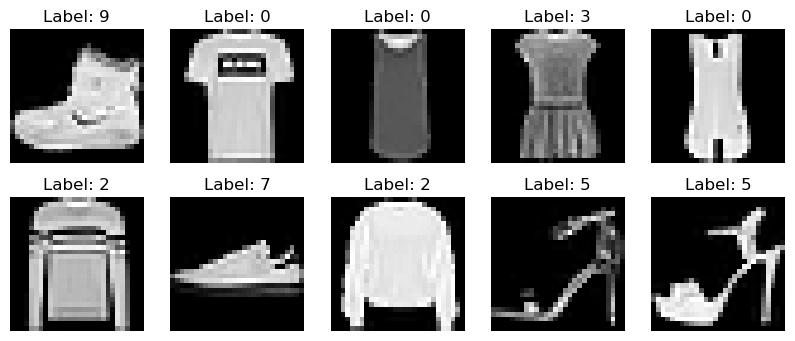

In [ ]:
display(pd.DataFrame({'label': FashionMNIST.classes}).T)

plt.figure(figsize=(10, 4))
for i, (sample, label) in zip(range(10), fashion_mnist['train']):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

## 합성곱 계층

튜닝만으로 목표를 달성하기는 어렵습니다. 데이터에서 정보를 보다 효과적으로 추출하는 가설 공간의 구성이 보다 중요합니다.

In [145]:
model = keras.Sequential([
    keras.Input(shape=(28, 28)), # 입력 형식
    layers.Rescaling(1/255), # 정규화 (0~1)
    layers.Reshape((28, 28, 1)), # 채널 차원 추가 (배치, 높이, 너비, 채널)
    # 합성곱층
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    # 출력층
    layers.Flatten(),
    layers.Dense(10, activation='softmax') # 확률값 출력
])
model.summary()
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(), # 2015년 제안된 최적화 기법 (자동 학습률)
    metrics=['accuracy']
)
# 학습
history = model.fit(fashion_mnist['train'].data, fashion_mnist['train'].targets, batch_size=100, epochs=10)

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)         │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 10)             │       216,330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,650 (846.29 KB)

 Trainable params: 216,650 (846.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8454 - loss: 0.4457
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8906 - loss: 0.3072
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9046 - loss: 0.2683
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9130 - loss: 0.2440
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9196 - loss: 0.2255
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9256 - loss: 0.2107
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9293 - loss: 0.1994
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9326 - loss: 0.1878
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9365 - loss: 0.1779
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9388 - loss: 0.1690
